# Clustered Summary

This is an attempt to implement the idea of [How to Summarize Large Documents with LangChain and OpenAI](https://medium.com/@myscale/how-to-summarize-large-documents-with-langchain-and-openai-4312568e80b1) in python with OpenAI again.

## Authenticate Google Drive

To load a document, we mount Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Get the text from PDF

In [ ]:
!pip install PyPDF2

import PyPDF2

def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as f:
        pdf_reader = PyPDF2.PdfReader(f)
        text = ''
        for page in pdf_reader.pages:
            text += page.extract_text()
        return text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 7.1 MB/s eta 0:00:00


Now we load our PDF and extracts its text.

In [ ]:
pdf_file_path = 'Towards Trust in Legal AI - Enhancing LLMs with Retrieval Augmented Generation.pdf'

try:
  extracted_text = extract_text_from_pdf('/content/drive/MyDrive/' + pdf_file_path)
  print(extracted_text[:3000] + '...') # we print only the first 3k chars

except FileNotFoundError:
  print(f"Error: File not found at {pdf_file_path}")
except Exception as e:
  print(f"An error occurred: {e}")

Towards Trust in Legal AI: Enhancing
LLMs with Retrieval Augmented
Generation
Master Thesis
by
Jonas Ferdinand Bucksch
M.Sc. Business Informatics
2338729
Karlsruhe Service Research and Innovation Hub (KSRI)
KIT Department of Economics and Management
Advisor: Dr. Michael Vössing
Second Advisor: Jens Decieux
Supervisor: Prof. Dr. Gerhard Satzger
Submitted: August 14, 2024
KIT – The Research University in the Helmholtz Association www.kit.eduPrologue
As I reach the end of this nine-year academic journey, I find myself reflecting deeply on
the entire path that has brought me to this moment. It all truly began with a mind-
changing year in Vancouver from 2014 to 2015, an experience that profoundly reshaped my
perspective and set the stage for everything that followed. Returning home, I embarked
on my university journey in 2015, side by side with my brother Jakob. Those early days
were memorable, with challenging exams and great experiences, leading to the completion
of our bachelor’s degree

## Partitioning

See https://medium.com/@anixlynch/7-chunking-strategies-for-langchain-b50dac194813

We partition the document content into chunks.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100, separators=["\n\n", ".", ";"], keep_separator='end')
chunks = splitter.split_text(extracted_text)
print(len(chunks))

332


In [ ]:
for i, chunk in enumerate(chunks[:3]):
    print(f"Chunk {i}: {chunk}\n")

print("...")

Chunk 0: Towards Trust in Legal AI: Enhancing
LLMs with Retrieval Augmented
Generation
Master Thesis
by
Jonas Ferdinand Bucksch
M.Sc. Business Informatics
2338729
Karlsruhe Service Research and Innovation Hub (KSRI)
KIT Department of Economics and Management
Advisor: Dr. Michael Vössing
Second Advisor: Jens Decieux
Supervisor: Prof. Dr. Gerhard Satzger
Submitted: August 14, 2024
KIT – The Research University in the Helmholtz Association www.kit.eduPrologue
As I reach the end of this nine-year academic journey, I find myself reflecting deeply on
the entire path that has brought me to this moment. It all truly began with a mind-
changing year in Vancouver from 2014 to 2015, an experience that profoundly reshaped my
perspective and set the stage for everything that followed. Returning home, I embarked
on my university journey in 2015, side by side with my brother Jakob.

Chunk 1: Returning home, I embarked
on my university journey in 2015, side by side with my brother Jakob. Those early d

## Embedding

To capture the meaning of each chunk, we use an embedding model.

### Setup OpenAI

Lets setup OpenAI.

In [ ]:
import os
from google.colab import userdata

openai_api_key = userdata.get('OPENAI_API_KEY')
if openai_api_key:
    os.environ['OPENAI_API_KEY'] = openai_api_key

In [ ]:
!pip install -qU langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.9 MB/s eta 0:00:00


In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

Now we test that OpenAI can be invoked by generating a text translation.

In [ ]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content="J'adore la programmation.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 31, 'total_tokens': 37, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_90122d973c', 'id': 'chatcmpl-BWp4guDlzmsVehfbOIosLpwf1wWzL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6e7c4ad6-c2de-4a95-a252-fc9e783b9205-0', usage_metadata={'input_tokens': 31, 'output_tokens': 6, 'total_tokens': 37, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### Create Embeddings

Now that OpenAI is ready, we create embeddings for all chunks.

In [ ]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large") #3072 dimensions

embedded_chunks = embeddings.embed_documents(chunks)

print(len(embedded_chunks))

332


In [ ]:
for i, vector in enumerate(embedded_chunks[:3]):
    print(f"Embedding for chunk {i}: {vector[:3]}...")

print("...")

Embedding for chunk 0: [0.020672526210546494, 0.006563645321875811, -0.028257181867957115]...
Embedding for chunk 1: [0.029788678511977196, 0.01241980493068695, -0.018680768087506294]...
Embedding for chunk 2: [0.00509260268881917, -0.010587816126644611, -0.021124236285686493]...
...


## Clustering

We have one vector per chunk. Now we group them into 10 clusters.

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0).fit(embedded_chunks)

In [ ]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

Each embedding vector has many dimensions. To better understand the next steps, we attempt to reduce it to 3 dimensions, which we can plot. This reduction is inherently lossy, so we dont expect the plot to show perfect clusters with reduced dimensions. The important operations are performed in full dimensional space.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embedded_chunks)

for i, reduced_embedding in enumerate(reduced_embeddings[:14]):
    print(reduced_embedding)
print("...")

[-0.09264432 -0.02669873 -0.01699555]
[-0.13603308 -0.22045996  0.16127439]
[-0.13177655 -0.18669241  0.19233349]
[ 0.04587655  0.28980834 -0.20286532]
[-0.15145906  0.23387589 -0.15098177]
[0.04123841 0.13245787 0.18785609]
[ 0.13620759 -0.06916417  0.05134276]
[-0.09674469 -0.28494838  0.01236746]
[ 0.12174826 -0.10436753 -0.00283983]
[-0.17065491 -0.15136805  0.06763009]
[-0.14906165  0.22524964  0.34148207]
[-0.18610307  0.22425288  0.21542873]
[0.11826003 0.05629785 0.0341503 ]
[ 0.29901353 -0.14962034  0.12929201]
...


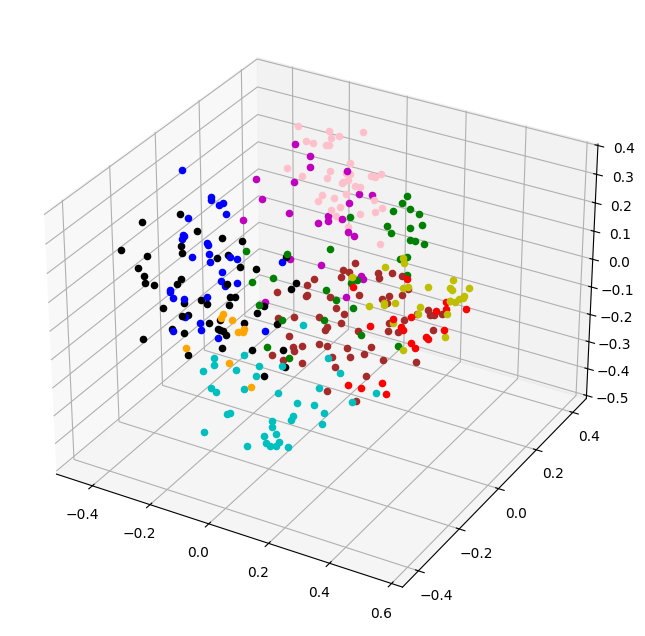

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'pink', 'brown', 'lime', 'teal', 'navy']

for i, reduced_embedding in enumerate(reduced_embeddings):
    label = labels[i]
    color = colors[label]
    ax.scatter(reduced_embedding[0], reduced_embedding[1], reduced_embedding[2], c=color)

plt.show()

## Cluster Representative

For each cluster we elect only one representative, which is closest to the cluster centroid.

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 47.3 MB/s eta 0:00:00


In [ ]:
import faiss
import numpy as np

In [ ]:
embedded_chunks_array = np.array(embedded_chunks)
embedded_chunks_array.shape

(332, 3072)

We build the index over all embeddings.

In [ ]:
index = faiss.IndexFlatIP(embedded_chunks_array.shape[1])
index.add(embedded_chunks_array)
index.ntotal

332

Lets test the vector search. If we search for the n-th chunk, we expect to find that chunks with a high similarity.

In [ ]:
query = chunks[15]
embedded_query = embeddings.embed_documents([query])

D, I = index.search(np.array(embedded_query), 4)
print(D)
print(I)

[[0.99996614 0.83073705 0.803582   0.6581643 ]]
[[ 15  14 315 187]]


Now we find the most similar vector to the centroid of each cluster. These will be our cluster representatives.

In [ ]:
D, I = index.search(centroids, 1)
print(D)
print(I)

[[0.51974   ]
 [0.61191523]
 [0.7417891 ]
 [0.6179322 ]
 [0.7112031 ]
 [0.75050545]
 [0.59281063]
 [0.72076654]
 [0.64433664]
 [0.7046163 ]]
[[187]
 [144]
 [233]
 [137]
 [309]
 [250]
 [121]
 [318]
 [ 79]
 [271]]


We concatenate all cluster representatives.

In [ ]:
cluster_representatives = np.array(chunks)[I].flatten().tolist()
concatenated_cluster_representatives = "\n\n".join(cluster_representatives)
concatenated_cluster_representatives

'The results of the ScrapeOps\nmonitoring are presented in the appendix, specifically in Figures 19, 20, 21, and 22. These\nfigures illustrate the progression of the scraper development process. Initially, a high\nnumber of scraping jobs were executed primarily for debugging purposes, reflected in the\nrelatively low number of pages scraped and a correspondingly high number of errors. As\nthe development stabilized and the debugging phase concluded, the number of scraped\npages increased, demonstrating the enhanced efficiency and effectiveness of the scraper in\nits later stages, scraping thousands of court rulings. Next, a comprehensive and detailed\ndescription of the decisionscraper is provided [83].\nSpiders and Web Scraping Logic. The decision scraper, located within the\ndata/decisionscraper directory, is a crucial tool for gathering legal documents from\nonline sources. The scraper is designed to handle the complexity of legal documents\nfrom www.rechtsprechung-im-internet.\n\nE

Finally we summarize the concatenated cluster representatives.

In [ ]:
def summarize(text: str):
  messages = [
      (
          "system",
          """Provide a summary of the following text. Your result must be detailed and atleast 2 paragraphs.
          Keep yourself short and concise. The shorter the better. The goal is to present a unified view of the content""",
      ),
      ("human", text),
  ]
  ai_msg = llm.invoke(messages)
  return ai_msg.content

In [ ]:
summary = summarize(concatenated_cluster_representatives)
summary

"The text provides a comprehensive overview of the development and evaluation of a web scraper and a legal chatbot, focusing on the methodologies and results of these technological advancements. Initially, the ScrapeOps monitoring results are discussed, highlighting the progression of the scraper development process. The early stages involved numerous scraping jobs primarily for debugging, which resulted in a high number of errors and a low number of pages scraped. However, as the development stabilized, the scraper's efficiency improved significantly, allowing it to scrape thousands of court rulings effectively. This improvement is visually represented in Figures 19 to 22 in the appendix. The decision scraper, located in the data/decisionscraper directory, is specifically designed to handle the complexity of legal documents from online sources, such as www.rechtsprechung-im-internet, and is evaluated based on criteria like Precision, Completeness, Relevance, Traceability, and Clarity.